# Бортников Павел Павлович 20215 Домашнее задание 5
---

In [311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # библиотека для построения графиков
import seaborn as sns # библиотека для построения графиков

from sklearn import preprocessing, decomposition, manifold, model_selection, pipeline, cluster, datasets, mixture, metrics

from sklearn import linear_model as lm
from sklearn.pipeline import Pipeline

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, roc_curve, precision_score, roc_auc_score, f1_score

from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler

from scipy import stats

%matplotlib inline

<AxesSubplot:>

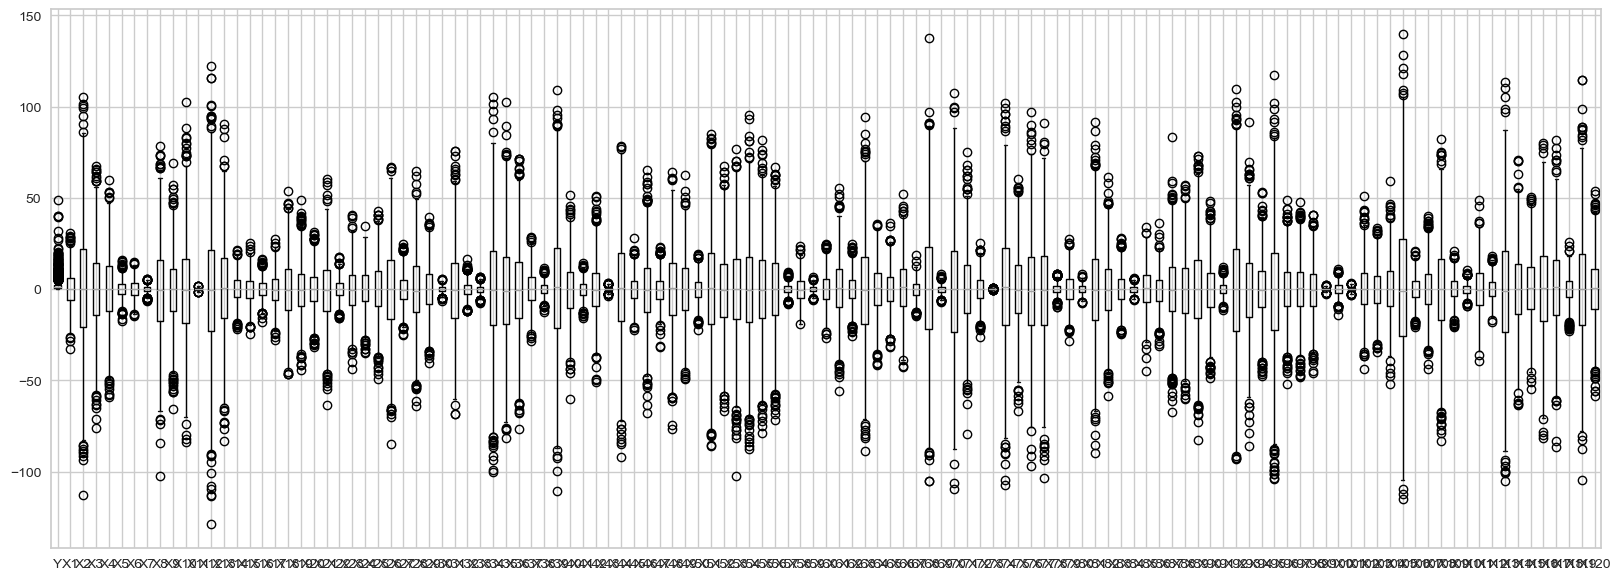

In [312]:
train = pd.read_csv("./hwfiles/Task5_train.csv")
test  = pd.read_csv("./hwfiles/Task5_test.csv")

train = train.iloc[:, 3:]
# utrainX = train.iloc[:, 1:]
# trainY = train.iloc[:, 0]  Я походу совершил изначально ошибку, что не скейлил таргет

# utrainX.boxplot(figsize=(20, 7))
train.boxplot(figsize=(20, 7))

Скейлим

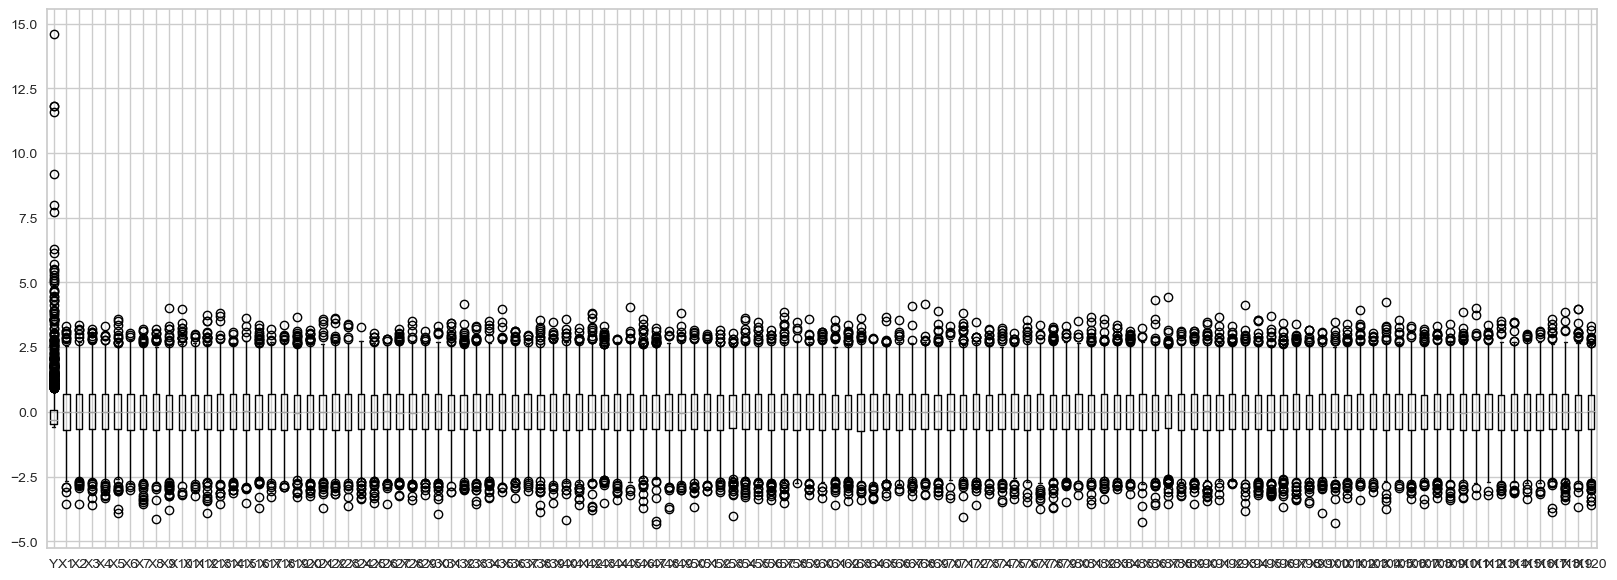

In [313]:
# trainX_with_Xoutliers = pd.DataFrame(
#     data=StandardScaler().fit_transform(utrainX.astype('float64')),
#     columns=utrainX.columns
# )
trainX_with_Xoutliers = pd.DataFrame(
    data=StandardScaler().fit_transform(train.astype('float64')),
    columns=train.columns
)
# trainY = trainX_with_Xoutliers.iloc[:, 0]
# trainX_with_Xoutliers = trainX_with_Xoutliers.iloc[:, 1:]
trainX_with_Xoutliers.boxplot(figsize=(20,7))


# trainX_with_Xoutliers['y'] = trainY
trainX_with_Xoutliers['y'] = trainX_with_Xoutliers['Y']
trainX_with_Xoutliers = trainX_with_Xoutliers.iloc[:, 1:]

Есть выбросы по иксам, по предварительной оценке на глаз, они не критичны, но можно подрезать

In [314]:
outlier_x_threshold = 100

trainX_with_Youtliers = trainX_with_Xoutliers[(np.abs(stats.zscore(trainX_with_Xoutliers.iloc[:, :-1])) < outlier_x_threshold).all(axis=1)]

# изначально 3, но потом оставил без фильтрации - вредит результату.

Посмотрим на выбросы по таргету

,y
z,
14.607525,14.607525
11.835731,11.835731
11.808766,11.808766
11.582685,11.582685
9.180533,9.180533
...,...
-0.598444,-0.598444
-0.598881,-0.598881
-0.598886,-0.598886


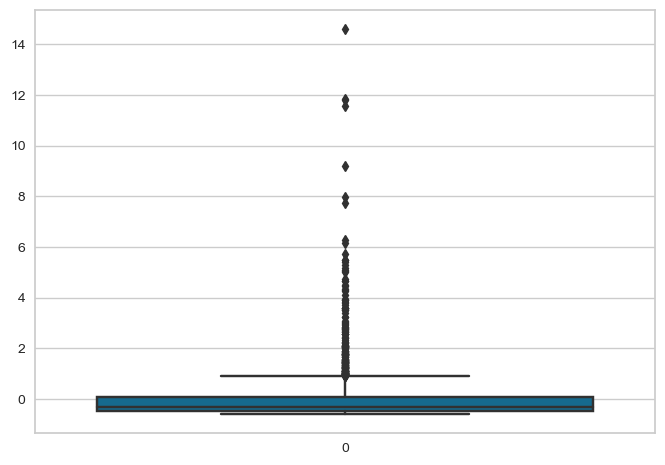

In [315]:
showyz = pd.DataFrame(
    data={
        'y': trainX_with_Youtliers['y'],
        'z': stats.zscore(trainX_with_Youtliers['y'])
    }).set_index(['z']).sort_index(ascending=False)
sns.boxplot(data=trainX_with_Youtliers['y'])
showyz

#Как можно заметить - всё грустно

Подрежем выбросы по таргету. Скорее всего так делать не стоит, и уникальные случаи надо как-то рассматривать

<AxesSubplot:>

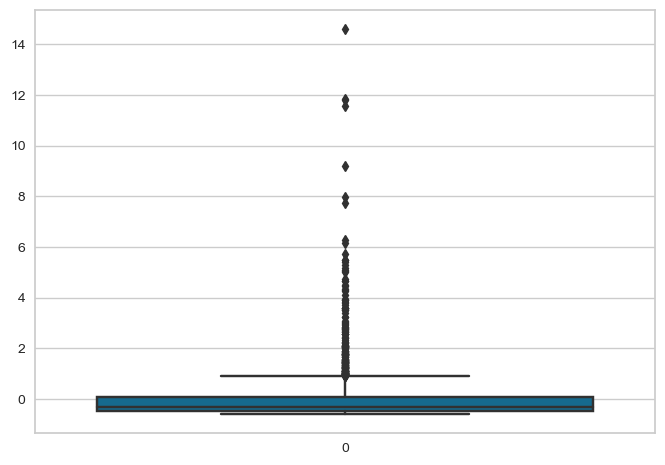

In [316]:
outlier_y_threshold = 100

trainX_without_importance = trainX_with_Youtliers[(np.abs(stats.zscore(trainX_with_Youtliers.iloc[:, -1:])) < outlier_y_threshold).all(axis=1)]
trainY = trainX_without_importance.iloc[:, -1]
sns.boxplot(trainY)

# Та же самая ситуация - удаление привело к падению результата. Было 3.

<AxesSubplot:>

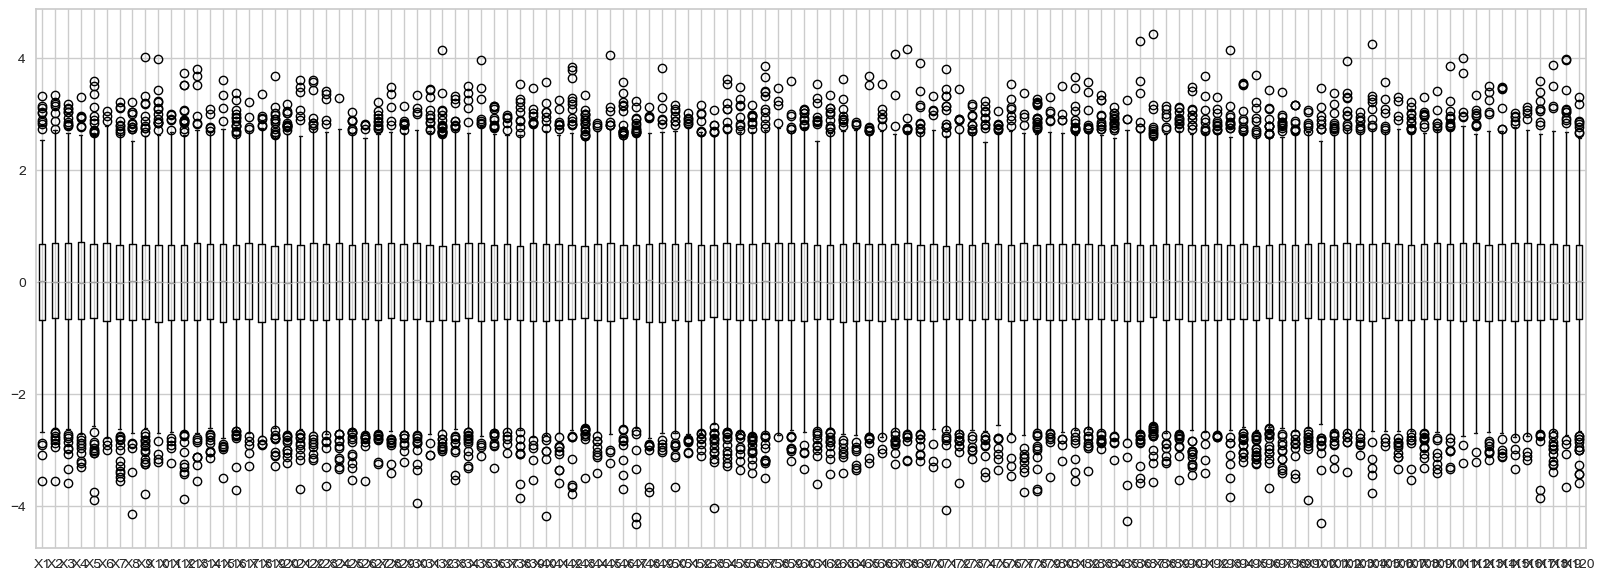

In [317]:
trainX_without_importance = trainX_without_importance.iloc[:, :-1]
trainX_without_importance.boxplot(figsize=(20,7))

Почистим фичи. Через лассо выделил ненулевые по важности фичи

In [318]:
from sklearn import linear_model

gscv = GridSearchCV(
    estimator=linear_model.Lasso(tol=0.001, max_iter=10000),
    param_grid={
        'alpha': np.arange(0.0001,1.0,0.001)
    },
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

search = gscv.fit(X=trainX_without_importance, y=trainY)

In [319]:
resdf = pd.DataFrame({
    "alpha": search.cv_results_['param_alpha'],
    "res":  search.cv_results_['mean_test_score']
})

coefficients = search.best_estimator_.coef_
importance = np.abs(coefficients)
# search.best_estimator_
# importance
important_columns = np.array(trainX_without_importance.columns)[importance > 0]

Почистим по корреляции с таргетом.

In [320]:
trainX_without_corr = trainX_without_importance[important_columns].copy()
trainXc = trainX_without_corr.copy()
trainXc['y'] = trainY
y_corr = trainXc.corr()['y'][:-1]

corr_importance_cols = y_corr.where(abs(y_corr) > 0.0).dropna().index.values
#этим я только хуже сделал, к сожалению, поэтому там 0.0 (было 0.2)

trainX = trainX_without_corr[corr_importance_cols].copy()

### Где-то на этом моменте я попробовал поставить хоть какой-то автомл. Я не поборол библиотеки и зависимости под М1 за 6 часов.

я очень расстроен(

upd: спустя еще 3 часа борьбы (не зря же прошлые 6 часов потратил), я через какой-то недофорк миниконды смог воткнуть что надо

In [321]:
import pycaret  # Когда оно перестало красным подчеркивать, под стулом кипяток был
from pycaret.regression import *
trainX['y'] = trainY
exp_reg1 = setup(data=trainX, target='y', session_id=1)

,Description,Value
0,session_id,1
1,Target,y
2,Original Data,"(2375, 62)"
3,Missing Values,False
4,Numeric Features,61
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1662, 61)"


In [322]:
best = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,0.2864,0.4638,0.6411,0.5585,0.2202,2.5070,0.4490
et,Extra Trees Regressor,0.3063,0.4786,0.6476,0.5537,0.2316,3.9147,0.2520
lightgbm,Light Gradient Boosting Machine,0.2752,0.4576,0.6412,0.5508,0.2194,3.2955,0.1170
br,Bayesian Ridge,0.3758,0.5276,0.6835,0.4997,0.2395,5.4627,0.0050
ridge,Ridge Regression,0.3892,0.5328,0.6894,0.4883,0.2453,5.9301,0.0100
lr,Linear Regression,0.3896,0.5331,0.6896,0.4877,0.2455,5.9370,0.0040
rf,Random Forest Regressor,0.3212,0.5435,0.6962,0.4710,0.2481,4.0270,0.7080
xgboost,Extreme Gradient Boosting,0.2916,0.5166,0.6858,0.4543,0.2317,3.4733,0.3460
huber,Huber Regressor,0.2801,0.6154,0.7312,0.4432,0.2331,2.3778,0.0110
omp,Orthogonal Matching Pursuit,0.4064,0.6141,0.7400,0.4128,0.2580,3.9899,0.0040


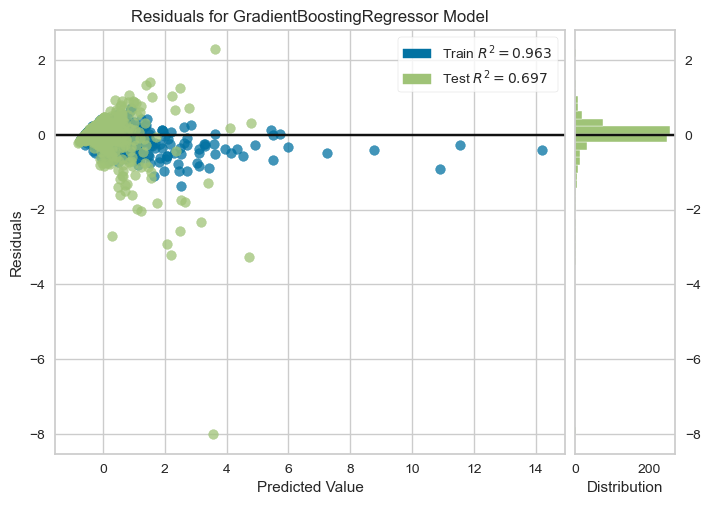

In [323]:
plot_model(best)

In [324]:
model = create_model(best)
huber = create_model('huber')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.3120,0.4425,0.6652,0.4864,0.2631,0.5921
1,0.3564,1.2284,1.1084,0.3143,0.2837,0.7126
2,0.3852,1.7935,1.3392,0.2652,0.2920,16.1847
3,0.2537,0.7683,0.8765,0.3172,0.2156,0.8666
4,0.2330,0.3481,0.5900,0.4451,0.1983,0.6516
5,0.2106,0.1843,0.4293,0.5453,0.1792,0.8766
6,0.2284,0.2476,0.4976,0.5265,0.2018,0.9876
7,0.2571,0.3890,0.6237,0.4779,0.2267,0.7118
8,0.2255,0.1830,0.4278,0.5953,0.1948,1.4192
9,0.3389,0.5695,0.7546,0.4585,0.2756,0.7757


In [325]:
tuned_model = tune_model(model)
tuned_huber = tune_model(huber)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.3376,0.3592,0.5993,0.5831,0.2368,1.4077
1,0.4180,1.1223,1.0594,0.3735,0.2718,1.8335
2,0.4273,1.6628,1.2895,0.3187,0.2718,31.4681
3,0.3190,0.7326,0.8559,0.3489,0.2201,2.0539
4,0.2850,0.3278,0.5725,0.4775,0.1943,1.4135
5,0.2808,0.1829,0.4276,0.5488,0.1999,2.0050
6,0.3037,0.2327,0.4824,0.5550,0.2053,2.4704
7,0.3190,0.3429,0.5856,0.5398,0.2223,1.8072
8,0.2752,0.1654,0.4067,0.6343,0.1967,3.4230
9,0.3724,0.4771,0.6907,0.5463,0.2451,1.7676


In [326]:
finalize_model(tuned_model)
# plot_model(tuned_model, plot='feature')
finalize_model(tuned_huber)

HuberRegressor(alpha=0.0001, epsilon=1.9, fit_intercept=False, max_iter=100,
               tol=1e-05, warm_start=False)

In [327]:
labels = trainX.columns

test['y'] = test['Y']

test_clear = test[labels]
# test_clearX = test_clear.iloc[:, :-1]
# test_clearY = test_clear['y']
# test_clear_stdx = pd.DataFrame(
#     data=StandardScaler().fit_transform(test_clearX.astype('float64')),
#     columns=test_clearX.columns
# )
test_clear_std = pd.DataFrame(
    data=StandardScaler().fit_transform(test_clear.astype('float64')),
    columns=test_clear.columns
)

test_clearY = test_clear_std['y']
test_clearX = test_clear_std.iloc[:, :-1]


test_predictions = predict_model(tuned_model, data=test_clearX)

print(
    pycaret.utils.check_metric(test_clearY, test_predictions['Label'], metric='MSE'),
    pycaret.utils.check_metric(test_clearY, test_predictions['Label'], metric='R2')
)

0.3572 0.6428


##### 0.3572 0.6428 - лассо

0.3747 0.6253 - без фильтрации
0.413 0.587 - лассо + Х
0.4038 0.5962 - лассо + Y (порог 6)
0.6029 0.3971 - лассо + Y (порог 1) (при этом на трейне 0.02 0.8)
0.4935 0.5065 - лассо + X + Y (порог 3-6)


#### Ситуация - чем больше отрезаю от трейна, тем больше метрики на трейне и тем меньше метрики на тесте. А не отрезать как бы и нельзя.

Единственное, что привело к видимому результату - отрезание через лассо. Всё остальное только ухудшало метрики на тесте.

Вычитал, что хубер лучше держит аутлаеры, из-за того что таргет по корню берется. Но видимо не лучше, чем гбр. Предположив, что если хубер не справился с транформацией таргета, то я скорее всего только хуже сделаю)

In [328]:
test_predictions2 = predict_model(tuned_huber, data=test_clearX)
print(
    pycaret.utils.check_metric(test_clearY, test_predictions2['Label'], metric='MSE'),
    pycaret.utils.check_metric(test_clearY, test_predictions2['Label'], metric='R2')
)

0.4944 0.5056


Собственно выкатываю итоговую модель

In [333]:
save_model(tuned_model, 'Finalized_GBR_model')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='y',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_strategy='mean...
                                            learning_rate=0.05, loss='ls',
                                            max_depth=4, max_features='sqrt',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.05,
                       